In [373]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [374]:
import pandas as pd

In [375]:
path1 = ('training_dataset_final.xlsx')
xl = pd.ExcelFile(path1)
print(xl.sheet_names)

['in']


In [376]:
df = xl.parse('in')

In [377]:
# Change all columns to the appropriate types
#df = df.convert_dtypes()
#print(df.dtypes)

In [378]:
#print(df)

In [379]:
df['PTIN'] = df['PTIN'].str.replace('-', '')
df['TAXPAYER_ID'] = df['TAXPAYER_ID'].str.replace('-', '')
df['FIRM_ID'] = df['FIRM_ID'].str.replace('-', '')
df['CLIENT_ID'] = df['CLIENT_ID'].str.replace('-', '')
df['ROUTING_NUMBER1'] = df['ROUTING_NUMBER1'].str.replace('-', '')
df['DEPOSIT_ACCOUNT1'] = df['DEPOSIT_ACCOUNT1'].str.replace('-', '')
df['ROUTING_NUMBER2'] = df['ROUTING_NUMBER2'].str.replace('-', '')
df['DEPOSIT_ACCOUNT2'] = df['DEPOSIT_ACCOUNT2'].str.replace('-', '')
df['ROUTING_NUMBER3'] = df['ROUTING_NUMBER3'].str.replace('-', '')
df['DEPOSIT_ACCOUNT3'] = df['DEPOSIT_ACCOUNT3'].str.replace('-', '')
df['IP_ADDRESS'] = df['IP_ADDRESS'].str.replace('-', '')
#print(df)

In [380]:
# Create a new DataFrame for extracted features
df_clean = pd.DataFrame({    
    'YEAR': df['FILED_DATETIME'].dt.year,
    'MONTH': df['FILED_DATETIME'].dt.month,
    'DAY': df['FILED_DATETIME'].dt.day,
    'HOUR': df['FILED_DATETIME'].dt.hour,
    'TAX_YEAR' : df['TAX_YEAR'],
    'REFUND' : df['REFUND'],# Copy REFUND directly
    'ZIPCODE' : df['ZIPCODE'],# Copy ZIPCODE directly
    'STATE_PLACEHOLDER' : df['STATE_PLACEHOLDER'],
    
    #Change STATE_ATTACHED & IS_SUSPICIOUS to int values
    'STATE_ATTACHED': df['STATE_ATTACHED'].astype(int),
    'IS_SUSPICIOUS': df['IS_SUSPICIOUS'].astype(int)
})
        
#print(df_clean)

In [381]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['TAXPAYER_ID', 'FIRM_ID', 'CLIENT_ID', 'ROUTING_NUMBER1', 
            'DEPOSIT_ACCOUNT1', 'ROUTING_NUMBER2', 'DEPOSIT_ACCOUNT2',
            'ROUTING_NUMBER3',  'DEPOSIT_ACCOUNT3',  'PTIN',  'IP_ADDRESS']:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df[col])
    label_encoders[col] = le
print(df_clean.dtypes)
print(df_clean)

YEAR                 int32
MONTH                int32
DAY                  int32
HOUR                 int32
TAX_YEAR             int64
REFUND               int64
ZIPCODE              int64
STATE_PLACEHOLDER    int64
STATE_ATTACHED       int64
IS_SUSPICIOUS        int64
TAXPAYER_ID          int64
FIRM_ID              int64
CLIENT_ID            int64
ROUTING_NUMBER1      int64
DEPOSIT_ACCOUNT1     int64
ROUTING_NUMBER2      int64
DEPOSIT_ACCOUNT2     int64
ROUTING_NUMBER3      int64
DEPOSIT_ACCOUNT3     int64
PTIN                 int64
IP_ADDRESS           int64
dtype: object
        YEAR  MONTH  DAY  HOUR  TAX_YEAR  REFUND  ZIPCODE  STATE_PLACEHOLDER  \
0       2021      1   20     0      2020    4206    33863                 47   
1       2021      1   20     6      2020    2276    23929                 30   
2       2021      1   20     7      2020    4373    56438                 17   
3       2021      1   20     8      2020    1339    37826                  6   
4       2021      1

In [382]:
# Dropping after extracting features
#df.drop('FILED_DATETIME', axis=1, inplace=True);

In [383]:
#df_clean = df_clean.fillna(0)
#print(df_clean.dtypes)
#print(df_clean)

In [384]:
# Divide the dataset into Suspicious and not suspicious
dfTrue = df_clean[df_clean['IS_SUSPICIOUS'] == 1]
dfFalse = df_clean[df_clean['IS_SUSPICIOUS'] == 0]

# Separate each dataset into percentages for train and evaluate
train_dfTrue, eval_dfTrue = train_test_split(dfTrue, test_size=0.2, random_state=42)
train_dfFalse, eval_dfFalse = train_test_split(dfFalse, test_size=0.2, random_state=42)

# Concatenate training set and shuffle
train_df = pd.concat([train_dfTrue, train_dfFalse])
train_df = train_df.sample(frac=1).reset_index(drop=True)

# Concatenate evaluation set and shuffle
eval_df = pd.concat([eval_dfTrue, eval_dfFalse])
eval_df = eval_df.sample(frac=1).reset_index(drop=True)

In [385]:
df.size, train_df.size, eval_df.size, dfTrue.size, dfFalse.size

(3675626, 3250002, 812532, 3927, 4058607)

In [386]:
X_train = train_df.drop('IS_SUSPICIOUS', axis=1);
Y_train = train_df['IS_SUSPICIOUS'];

In [387]:
X_eval = eval_df.drop('IS_SUSPICIOUS', axis=1);
Y_eval = eval_df['IS_SUSPICIOUS'];

In [388]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [389]:
import xgboost as xgb

In [390]:
#Instances of xgboost model
dtrain = xgb.DMatrix(X_train, label=Y_train, enable_categorical=True)
deval = xgb.DMatrix(X_eval, label=Y_eval, enable_categorical=True)   

In [444]:
# Set parameters for training
params = {
    'max_depth': 6,#depth of tree
    'eta': 0.5, #learning rate
    'objective': 'binary:logistic',
    'eval_metric': 'auc' # Could try with diff. eval metrics e.g. error
    #Can use tree_method to change algo
}
num_rounds = 1000
   

In [445]:
# Train our model using xbg.train
bst = xgb.train(params, dtrain, num_rounds, evals=[(deval, 'eval')], early_stopping_rounds=10)

[0]	eval-auc:0.83973
[1]	eval-auc:0.88701
[2]	eval-auc:0.88636
[3]	eval-auc:0.88646
[4]	eval-auc:0.88652
[5]	eval-auc:0.95864
[6]	eval-auc:0.96096
[7]	eval-auc:0.96562
[8]	eval-auc:0.96496
[9]	eval-auc:0.99682
[10]	eval-auc:0.99693
[11]	eval-auc:0.99747
[12]	eval-auc:0.99703
[13]	eval-auc:0.99840
[14]	eval-auc:0.99858
[15]	eval-auc:0.99881
[16]	eval-auc:0.99883
[17]	eval-auc:0.99927
[18]	eval-auc:0.99920
[19]	eval-auc:0.99947
[20]	eval-auc:0.99958
[21]	eval-auc:0.99967
[22]	eval-auc:0.99964
[23]	eval-auc:0.99968
[24]	eval-auc:0.99962
[25]	eval-auc:0.99957
[26]	eval-auc:0.99967
[27]	eval-auc:0.99965
[28]	eval-auc:0.99962
[29]	eval-auc:0.99960
[30]	eval-auc:0.99958
[31]	eval-auc:0.99953
[32]	eval-auc:0.99960
[33]	eval-auc:0.99969
[34]	eval-auc:0.99971
[35]	eval-auc:0.99972
[36]	eval-auc:0.99970
[37]	eval-auc:0.99975
[38]	eval-auc:0.99974
[39]	eval-auc:0.99977
[40]	eval-auc:0.99975
[41]	eval-auc:0.99975
[42]	eval-auc:0.99977
[43]	eval-auc:0.99979
[44]	eval-auc:0.99979
[45]	eval-auc:0.9998

In [446]:
# Used to perform predictions on evaulation set
y_pred = bst.predict(deval)

In [447]:
# Can be used to get the best iteration
#y_pred = bst.predict(deval, iteration_range=(0, bst.best_iteration + 1))
#print(y_pred)

In [448]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

y_pred_class = (y_pred > 0.5).astype(int)
print("Evaluation metrics:")
print("Accuracy:", accuracy_score(Y_eval, np.round(y_pred)))
print("Precision:", precision_score(Y_eval, np.round(y_pred)))
print("Recall:", recall_score(Y_eval, np.round(y_pred)))
print("F1-score:", f1_score(Y_eval, np.round(y_pred)))
print("AUC-ROC:", roc_auc_score(Y_eval, np.round(y_pred)))

Evaluation metrics:
Accuracy: 0.9997673937764913
Precision: 0.9393939393939394
Recall: 0.8157894736842105
F1-score: 0.8732394366197183
AUC-ROC: 0.9078688662983064


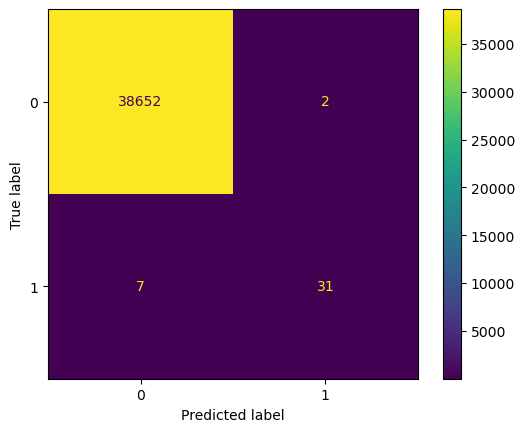

In [449]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_pred contains continuous predictions
# Convert probabilities to binary labels using a threshold of 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(Y_eval, y_pred_binary)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [410]:
import seaborn as sn 
import matplotlib.pyplot as plt
import numpy as np 

# prints data that will be plotted 
# columns shown here are selected by corr() since 
# they are ideal for the plot 
#print(df_clean.corr())

# Assuming df_clean is your DataFrame
# Select only numeric columns for the heatmap
#numeric_df = df_clean.select_dtypes(include=[np.number])

# plotting correlation heatmap 
#dataplot = sn.heatmap(df_clean.corr(), annot=True) 

# Change the size of the heatmap
#plt.figure(figsize=(50,15))

#Triangle Correlation heatmap
#define the mask to set the values in the upper triangle to True
#mask = np.triu(np.ones_like(df_clean.corr()))
#heatmap = sn.heatmap(df_clean.corr(), mask=mask, vmin=-1, vmax=1, cmap='BrBG')
#heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

#Features corerelating with Refund
#df_clean.corr()[['REFUND']].sort_values(by='REFUND', ascending=False)
#plt.figure(figsize=(8, 12))
#heatmap = sn.heatmap(df_clean.corr()[['REFUND']].sort_values(by='REFUND', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title('Features Correlating with REFUND', fontdict={'fontsize':18}, pad=16);

# displaying heatmap 
#plt.show() 